
<a id='mc'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Finite Markov Chains

## Contents

- [Finite Markov Chains](#Finite-Markov-Chains)  
  - [Overview](#Overview)  
  - [Definitions](#Definitions)  
  - [Simulation](#Simulation)  
  - [Marginal Distributions](#Marginal-Distributions)  
  - [Irreducibility and Aperiodicity](#Irreducibility-and-Aperiodicity)  
  - [Stationary Distributions](#Stationary-Distributions)  
  - [Ergodicity](#Ergodicity)  
  - [Computing Expectations](#Computing-Expectations)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

Markov chains are one of the most useful classes of stochastic processes, being

- simple, flexible and supported by many elegant theoretical results  
- valuable for building intuition about random dynamic models  
- central to quantitative modeling in their own right  


You will find them in many of the workhorse models of economics and finance

In this lecture we review some of the theory of Markov chains

We will also introduce some of the high quality routines for working with Markov chains available in [QuantEcon.jl](http://quantecon.org/julia_index.html)

Prerequisite knowledge is basic probability and linear algebra

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.2.0")

Activated /home/qebuild/repos/lecture-source-jl/_build/website/jupyter/Project.toml
Info quantecon-notebooks-julia 0.1.0 activated, 0.2.0 requested


In [2]:
using LinearAlgebra, Statistics
using Distributions, Plots, Printf, QuantEcon, Random
gr(fmt = :png);

## Definitions

The following concepts are fundamental


<a id='finite-dp-stoch-mat'></a>

### Stochastic Matrices


<a id='index-2'></a>
A **stochastic matrix** (or **Markov matrix**)  is an $ n \times n $ square matrix $ P $
such that

1. each element of $ P $ is nonnegative, and  
1. each row of $ P $ sums to one  


Each row of $ P $ can be regarded as a probability mass function over $ n $ possible outcomes

It is too not difficult to check <sup><a href=#pm id=pm-link>[1]</a></sup> that if $ P $ is a stochastic matrix, then so is the $ k $-th power $ P^k $ for all $ k \in \mathbb N $

### Markov Chains


<a id='index-4'></a>
There is a close connection between stochastic matrices and Markov chains

To begin, let $ S $ be a finite set with $ n $ elements $ \{x_1, \ldots, x_n\} $

The set $ S $ is called the **state space** and $ x_1, \ldots, x_n $ are the **state values**

A **Markov chain** $ \{X_t\} $ on $ S $ is a sequence of random variables on $ S $ that have the **Markov property**

This means that, for any date $ t $ and any state $ y \in S $,


<a id='equation-fin-markov-mp'></a>
$$
\mathbb P \{ X_{t+1} = y  \,|\, X_t \}
= \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots \} \tag{1}
$$

In other words, knowing the current state is enough to know probabilities for future states

In particular, the dynamics of a Markov chain are fully determined by the set of values


<a id='equation-mpp'></a>
$$
P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
\qquad (x, y \in S) \tag{2}
$$

By construction,

- $ P(x, y) $ is the probability of going from $ x $ to $ y $ in one unit of time (one step)  
- $ P(x, \cdot) $ is the conditional distribution of $ X_{t+1} $ given $ X_t = x $  


We can view $ P $ as a stochastic matrix where

$$
P_{ij} = P(x_i, x_j)
\qquad 1 \leq i, j \leq n
$$

Going the other way, if we take a stochastic matrix $ P $, we can generate a Markov
chain $ \{X_t\} $ as follows:

- draw $ X_0 $ from some specified distribution  
- for each $ t = 0, 1, \ldots $, draw $ X_{t+1} $ from $ P(X_t,\cdot) $  


By construction, the resulting process satisfies [(2)](#equation-mpp)


<a id='mc-eg1'></a>

### Example 1

Consider a worker who, at any given time $ t $, is either unemployed (state 1) or employed (state 2)

Suppose that, over a one month period,

1. An unemployed worker finds a job with probability $ \alpha \in (0, 1) $  
1. An employed worker loses her job and becomes unemployed with probability $ \beta \in (0, 1) $  


In terms of a Markov model, we have

- $ S = \{ 1, 2\} $  
- $ P(1, 2) = \alpha $ and $ P(2, 1) = \beta $  


We can write out the transition probabilities in matrix form as

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{array}
  \right)
$$

Once we have the values $ \alpha $ and $ \beta $, we can address a range of questions, such as

- What is the average duration of unemployment?  
- Over the long-run, what fraction of time does a worker find herself unemployed?  
- Conditional on employment, what is the probability of becoming unemployed at least once over the next 12 months?  


We’ll cover such applications below


<a id='mc-eg2'></a>

### Example 2

Using  US unemployment data, Hamilton [[Ham05]](https://lectures.quantecon.org/zreferences.html#hamilton2005) estimated the stochastic matrix

$$
P =
\left(
  \begin{array}{ccc}
     0.971 & 0.029 & 0 \\
     0.145 & 0.778 & 0.077 \\
     0 & 0.508 & 0.492
  \end{array}
\right)
$$

where

- the frequency is monthly  
- the first state represents “normal growth”  
- the second state represents “mild recession”  
- the third state represents “severe recession”  


For example, the matrix tells us that when the state is normal growth, the state will again be normal growth next month with probability 0.97

In general, large values on the main diagonal indicate persistence in the process $ \{ X_t \} $

This Markov process can also be represented as a directed graph, with edges labeled by transition probabilities

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/hamilton_graph.png" style="width:80%;height:80%">

  
Here “ng” is normal growth, “mr” is mild recession, etc.

## Simulation


<a id='index-5'></a>
One natural way to answer questions about Markov chains is to simulate them

(To approximate the probability of event $ E $, we can simulate many times and count the fraction of times that $ E $ occurs)

Nice functionality for simulating Markov chains exists in [QuantEcon.jl](http://quantecon.org/julia_index.html)

- Efficient, bundled with lots of other useful routines for handling Markov chains  


However, it’s also a good exercise to roll our own routines — let’s do that first and then come back to the methods in [QuantEcon.jl](http://quantecon.org/julia_index.html)

In these exercises we’ll take the state space to be $ S = 1,\ldots, n $

### Rolling our own

To simulate a Markov chain, we need its stochastic matrix $ P $ and either an initial state or a probability distribution $ \psi $ for initial state to be drawn from

The Markov chain is then constructed as discussed above.  To repeat:

1. At time $ t=0 $, the $ X_0 $ is set to some fixed state or chosen from $ \psi $  
1. At each subsequent time $ t $, the new state $ X_{t+1} $ is drawn from $ P(X_t, \cdot) $  


In order to implement this simulation procedure, we need a method for generating draws from a discrete distributions

For this task we’ll use a Categorical random variable (i.e. a discrete random variable with assigned probabilities)

In [3]:
d = Categorical([0.5, 0.3, 0.2]) # 3 discrete states
@show rand(d, 5)
@show supertype(typeof(d))
@show pdf(d, 1) # the probability to be in state 1
@show support(d)
@show pdf.(d, support(d)); # broadcast the pdf over the whole support

rand(d, 5) = [1, 1, 2, 2, 2]
supertype(typeof(d)) = 

Distribution{Univariate,Discrete}


pdf(d, 1) = 0.5
support(d) = Base.OneTo(3)


pdf.(d, support(d)) = [0.5, 0.3, 0.2]


We’ll write our code as a function that takes the following three arguments

- A stochastic matrix `P`  
- An initial state `init`  
- A positive integer `sample_size` representing the length of the time series the function should return  

In [4]:
function mc_sample_path(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # square required
    N = size(P)[1] # should be square

    # create vector of discrete RVs for each row
    dists = [Categorical(P[i, :]) for i in 1:N]

    # setup the simulation
    X = fill(0, sample_size) # allocate memory, or zeros(Int64, sample_size)
    X[1] = init # set the initial state

    for t in 2:sample_size
        dist = dists[X[t-1]] # get discrete RV from last state's transition distribution
        X[t] = rand(dist) # draw new value
    end
    return X
end

mc_sample_path (generic function with 1 method)

Let’s see how it works using the small matrix


<a id='equation-fm-smat'></a>
$$
P :=
\left(
  \begin{array}{cc}
     0.4 & 0.6  \\
     0.2 & 0.8
  \end{array}
\right) \tag{3}
$$

As we’ll see later, for a long series drawn from `P`, the fraction of the sample that takes value 1 will be about 0.25

If you run the following code you should get roughly that answer

In [5]:
P = [0.4 0.6; 0.2 0.8]
X = mc_sample_path(P, sample_size = 100_000); # note 100_000 = 100000
μ_1 = count(X .== 1)/length(X) # .== broadcasts test for equality. Could use mean(X .== 1)

0.24993

### Using QuantEcon’s Routines

As discussed above, [QuantEcon.jl](http://quantecon.org/julia_index.html) has routines for handling Markov chains, including simulation

Here’s an illustration using the same P as the preceding example

In [6]:
P = [0.4 0.6; 0.2 0.8];
mc = MarkovChain(P)
X = simulate(mc, 100_000);
μ_2 = count(X .== 1)/length(X) # or mean(x -> x == 1, X)

0.24734

#### Adding state values and initial conditions

If we wish to, we can provide a specification of state values to `MarkovChain`

These state values can be integers, floats, or even strings

The following code illustrates

In [7]:
mc = MarkovChain(P, ["unemployed", "employed"])
simulate(mc, 4, init = 1) # start at state 1

4-element Array{String,1}:
 "unemployed"
 "employed"  
 "employed"  
 "employed"  

In [8]:
simulate(mc, 4, init = 2) # start at state 2

4-element Array{String,1}:
 "employed"  
 "employed"  
 "unemployed"
 "unemployed"

In [9]:
simulate(mc, 4) # start with randomly chosen initial condition

4-element Array{String,1}:
 "unemployed"
 "employed"  
 "employed"  
 "employed"  

In [10]:
simulate_indices(mc, 4)

4-element Array{Int64,1}:
 2
 2
 2
 2


<a id='mc-md'></a>

## Marginal Distributions


<a id='index-7'></a>
Suppose that

1. $ \{X_t\} $ is a Markov chain with stochastic matrix $ P $  
1. the distribution of $ X_t $ is known to be $ \psi_t $  


What then is the distribution of $ X_{t+1} $, or, more generally, of $ X_{t+m} $?

### Solution

Let $ \psi_t $ be the distribution of $ X_t $ for $ t = 0, 1, 2, \ldots $

Our first aim is to find $ \psi_{t + 1} $ given $ \psi_t $ and $ P $

To begin, pick any $ y  \in S $

Using the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability), we can decompose the probability that $ X_{t+1} = y $ as follows:

$$
\mathbb P \{X_{t+1} = y \}
   = \sum_{x \in S} \mathbb P \{ X_{t+1} = y \, | \, X_t = x \}
               \cdot \mathbb P \{ X_t = x \}
$$

In words, to get the probability of being at $ y $ tomorrow, we account for
all  ways this can happen and sum their probabilities

Rewriting this statement in terms of  marginal and conditional probabilities gives


<a id='mc-fdd'></a>
$$
\psi_{t+1}(y) = \sum_{x \in S} P(x,y) \psi_t(x)
$$

There are $ n $ such equations, one for each $ y \in S $

If we think of $ \psi_{t+1} $ and $ \psi_t $ as *row vectors* (as is traditional in this literature), these $ n $ equations are summarized by the matrix expression


<a id='mc-fddv'></a>

<a id='equation-fin-mc-fr'></a>
$$
\psi_{t+1} = \psi_t P \tag{4}
$$

In other words, to move the distribution forward one unit of time, we postmultiply by $ P $

By repeating this $ m $ times we move forward $ m $ steps into the future

Hence, iterating on [(4)](#equation-fin-mc-fr), the expression $ \psi_{t+m} = \psi_t P^m $ is also valid — here $ P^m $ is the $ m $-th power of $ P $


<a id='mc-exfmar'></a>
As a special case, we see that if $ \psi_0 $ is the initial distribution from
which $ X_0 $ is drawn, then $ \psi_0 P^m $ is the distribution of
$ X_m $

This is very important, so let’s repeat it


<a id='equation-mdfmc'></a>
$$
X_0 \sim \psi_0 \quad \implies \quad X_m \sim \psi_0 P^m \tag{5}
$$

and, more generally,


<a id='equation-mdfmc2'></a>
$$
X_t \sim \psi_t \quad \implies \quad X_{t+m} \sim \psi_t P^m \tag{6}
$$


<a id='finite-mc-mstp'></a>

### Multiple Step Transition Probabilities

We know that the probability of transitioning from $ x $ to $ y $ in
one step is $ P(x,y) $

It turns out that the probability of transitioning from $ x $ to $ y $ in
$ m $ steps is $ P^m(x,y) $, the $ (x,y) $-th element of the
$ m $-th power of $ P $

To see why, consider again [(6)](#equation-mdfmc2), but now with $ \psi_t $ putting all probability on state $ x $

- 1 in the $ x $-th position and zero elsewhere  


Inserting this into [(6)](#equation-mdfmc2), we see that, conditional on $ X_t = x $, the distribution of $ X_{t+m} $ is the $ x $-th row of $ P^m $

In particular

$$
\mathbb P \{X_{t+m} = y \} = P^m(x, y) = (x, y) \text{-th element of } P^m
$$

### Example: Probability of Recession


<a id='index-8'></a>
Recall the stochastic matrix $ P $ for recession and growth [considered above](#mc-eg2)

Suppose that the current state is unknown — perhaps statistics are available only  at the *end* of the current month

We estimate the probability that the economy is in state $ x $ to be $ \psi(x) $

The probability of being in recession (either mild or severe) in 6 months time is given by the inner product

$$
\psi P^6
\cdot
\left(
  \begin{array}{c}
     0 \\
     1 \\
     1
  \end{array}
\right)
$$


<a id='mc-eg1-1'></a>

### Example 2: Cross-Sectional Distributions


<a id='index-9'></a>
The marginal distributions we have been studying can be viewed either as
probabilities or as cross-sectional frequencies in large samples

To illustrate, recall our model of employment / unemployment dynamics for a given worker [discussed above](#mc-eg1)

Consider a large (i.e., tending to infinite) population of workers, each of whose lifetime experiences are described by the specified dynamics, independently of one another

Let $ \psi $ be the current *cross-sectional* distribution over $ \{ 1, 2 \} $

- For example, $ \psi(1) $ is the unemployment rate  


The cross-sectional distribution records the fractions of workers employed and unemployed at a given moment

The same distribution also describes the fractions of  a particular worker’s career spent being employed and unemployed, respectively

## Irreducibility and Aperiodicity


<a id='index-11'></a>
Irreducibility and aperiodicity are central concepts of modern Markov chain theory

Let’s see what they’re about

### Irreducibility

Let $ P $ be a fixed stochastic matrix

Two states $ x $ and $ y $ are said to **communicate** with each other if
there exist positive integers $ j $ and $ k $ such that

$$
P^j(x, y) > 0
\quad \text{and} \quad
P^k(y, x) > 0
$$

In view of our discussion [above](#finite-mc-mstp), this means precisely
that

- state $ x $ can be reached eventually from state $ y $, and  
- state $ y $ can be reached eventually from state $ x $  


The stochastic matrix $ P $ is called **irreducible** if all states
communicate; that is, if $ x $ and $ y $ communicate for all
$ (x, y) $ in $ S \times S $

For example, consider the following transition probabilities for wealth of a fictitious set of
households

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/mc_irreducibility1.png" style="width:100%;height:100%">

  
We can translate this into a stochastic matrix, putting zeros where
there’s no edge between nodes

$$
P :=
\left(
  \begin{array}{ccc}
     0.9 & 0.1 & 0 \\
     0.4 & 0.4 & 0.2 \\
     0.1 & 0.1 & 0.8
  \end{array}
\right)
$$

It’s clear from the graph that this stochastic matrix is irreducible: we can
reach any state from any other state eventually

We can also test this using [QuantEcon.jl](http://quantecon.org/julia_index.html)’s MarkovChain class

In [11]:
P = [0.9 0.1 0.0; 0.4 0.4 0.2; 0.1 0.1 0.8];
mc = MarkovChain(P)
is_irreducible(mc)

true

Here’s a more pessimistic scenario, where the poor are poor forever

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/mc_irreducibility2.png" style="width:100%;height:100%">

  
This stochastic matrix is not irreducible, since, for example, rich is not accessible from poor

Let’s confirm this

In [12]:
P = [1.0 0.0 0.0; 0.1 0.8 0.1; 0.0 0.2 0.8];
mc = MarkovChain(P);
is_irreducible(mc)

false

We can also determine the “communication classes,” or the sets of communicating states (where communication refers to a nonzero probability of moving in each direction).

In [13]:
communication_classes(mc)

2-element Array{Array{Int64,1},1}:
 [1]   
 [2, 3]

It might be clear to you already that irreducibility is going to be important in terms of long run outcomes

For example, poverty is a life sentence in the second graph but not the first

We’ll come back to this a bit later

### Aperiodicity

Loosely speaking, a Markov chain is called periodic if it cycles in a predictible way, and aperiodic otherwise

Here’s a trivial example with three states

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/mc_aperiodicity1.png" style="width:100%;height:100%">

  
The chain cycles with period 3:

In [14]:
P = [0 1 0; 0 0 1; 1 0 0];
mc = MarkovChain(P);
period(mc)

3

More formally, the **period** of a state $ x $ is the greatest common divisor
of the set of integers

$$
D(x) := \{j \geq 1 : P^j(x, x) > 0\}
$$

In the last example, $ D(x) = \{3, 6, 9, \ldots\} $ for every state $ x $, so the period is 3

A stochastic matrix is called **aperiodic** if the period of every state is 1, and **periodic** otherwise

For example, the stochastic matrix associated with the transition probabilities below is periodic because, for example, state $ a $ has period 2

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/mc_aperiodicity2.png" style="width:100%;height:100%">

  
We can confirm that the stochastic matrix is periodic as follows

In [15]:
P = zeros(4, 4);
P[1, 2] = 1;
P[2, 1] = P[2, 3] = 0.5;
P[3, 2] = P[3, 4] = 0.5;
P[4, 3] = 1;
mc = MarkovChain(P);
period(mc)

2

In [16]:
is_aperiodic(mc)

false

## Stationary Distributions


<a id='index-13'></a>
As seen in [(4)](#equation-fin-mc-fr), we can shift probabilities forward one unit of time via postmultiplication by $ P $

Some distributions are invariant under this updating process — for example,

In [17]:
P = [.4 .6; .2 .8];
ψ = [0.25, 0.75];
ψ' * P

1×2 Adjoint{Float64,Array{Float64,1}}:
 0.25  0.75

Such distributions are called **stationary**, or **invariant**


<a id='mc-stat-dd'></a>
Formally, a distribution $ \psi^* $ on $ S $ is called **stationary** for $ P $ if $ \psi^* = \psi^* P $

From this equality we immediately get $ \psi^* = \psi^* P^t $ for all $ t $

This tells us an important fact: If the distribution of $ X_0 $ is a stationary distribution, then $ X_t $ will have this same distribution for all $ t $

Hence stationary distributions have a natural interpretation as stochastic steady states — we’ll discuss this more in just a moment

Mathematically, a stationary distribution is a fixed point of $ P $ when $ P $ is thought of as the map $ \psi \mapsto \psi P $ from (row) vectors to (row) vectors

**Theorem.** Every stochastic matrix $ P $ has at least one stationary distribution

(We are assuming here that the state space $ S $ is finite; if not more assumptions are required)

For a proof of this result you can apply [Brouwer’s fixed point theorem](https://en.wikipedia.org/wiki/Brouwer_fixed-point_theorem), or see [EDTC](http://johnstachurski.net/edtc.html), theorem 4.3.5

There may in fact be many stationary distributions corresponding to a given stochastic matrix $ P $

- For example, if $ P $ is the identity matrix, then all distributions are stationary  


Since stationary distributions are long run equilibria, to get uniqueness we require that initial conditions are not infinitely persistent

Infinite persistence of initial conditions occurs if certain regions of the
state space cannot be accessed from other regions, which is the opposite of irreducibility

This gives some intuition for the following fundamental theorem


<a id='mc-conv-thm'></a>
**Theorem.** If $ P $ is both aperiodic and irreducible, then

1. $ P $ has exactly one stationary distribution $ \psi^* $  
1. For any initial distribution $ \psi_0 $, we have $ \| \psi_0 P^t - \psi^* \| \to 0 $ as $ t \to \infty $  


For a proof, see, for example, theorem 5.2 of [[Haggstrom02]](https://lectures.quantecon.org/zreferences.html#haggstrom2002finite)

(Note that part 1 of the theorem requires only irreducibility, whereas part 2
requires both irreducibility and aperiodicity)

A stochastic matrix satisfying the conditions of the theorem is sometimes called **uniformly ergodic**

One easy sufficient condition for aperiodicity and irreducibility is that every element of $ P $ is strictly positive

- Try to convince yourself of this  

### Example

Recall our model of employment / unemployment dynamics for a given worker [discussed above](#mc-eg1)

Assuming $ \alpha \in (0,1) $ and $ \beta \in (0,1) $, the uniform ergodicity condition is satisfied

Let $ \psi^* = (p, 1-p) $ be the stationary distribution, so that $ p $ corresponds to unemployment (state 1)

Using $ \psi^* = \psi^* P $ and a bit of algebra yields

$$
p = \frac{\beta}{\alpha + \beta}
$$

This is, in some sense, a steady state probability of unemployment — more on interpretation below

Not surprisingly it tends to zero as $ \beta \to 0 $, and to one as $ \alpha \to 0 $

### Calculating Stationary Distributions


<a id='index-14'></a>
As discussed above, a given Markov matrix $ P $ can have many stationary distributions

That is, there can be many row vectors $ \psi $ such that $ \psi = \psi P $

In fact if $ P $ has two distinct stationary distributions $ \psi_1,
\psi_2 $ then it has infinitely many, since in this case, as you can verify,

$$
\psi_3 := \lambda \psi_1 + (1 - \lambda) \psi_2
$$

is a stationary distribution for $ P $ for any $ \lambda \in [0, 1] $

If we restrict attention to the case where only one stationary distribution exists, one option for finding it is to try to solve the linear system $ \psi (I_n - P) = 0 $ for $ \psi $, where $ I_n $ is the $ n \times n $ identity

But the zero vector solves this equation

Hence we need to impose the restriction that the solution must be a probability distribution

A suitable algorithm is implemented in [QuantEcon.jl](http://quantecon.org/julia_index.html) — the next code block illustrates

In [18]:
P = [.4 .6; .2 .8];
mc = MarkovChain(P);
stationary_distributions(mc)

1-element Array{Array{Float64,1},1}:
 [0.25, 0.7499999999999999]

The stationary distribution is unique

### Convergence to Stationarity


<a id='index-15'></a>
Part 2 of the Markov chain convergence theorem [stated above](#mc-conv-thm) tells us that the distribution of $ X_t $ converges to the stationary distribution regardless of where we start off

This adds considerable weight to our interpretation of $ \psi^* $ as a stochastic steady state

The convergence in the theorem is illustrated in the next figure

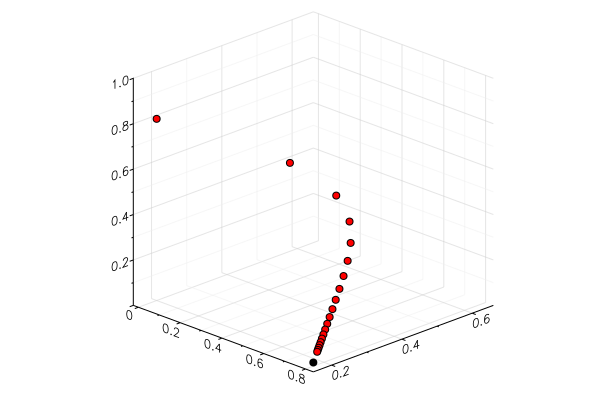

In [19]:
P = [0.971 0.029 0.000
     0.145 0.778 0.077
     0.000 0.508 0.492] # stochastic matrix

ψ = [0.0 0.2 0.8] # initial distribution

t = 20 # path length
x_vals = zeros(t)
y_vals = similar(x_vals)
z_vals = similar(x_vals)
colors = [repeat([:red], 20); :black] # for plotting

for i in 1:t
    x_vals[i] = ψ[1]
    y_vals[i] = ψ[2]
    z_vals[i] = ψ[3]
    ψ = ψ * P # update distribution
end

mc = MarkovChain(P)
ψ_star = stationary_distributions(mc)[1]
x_star, y_star, z_star = ψ_star # unpack the stationary dist
plt = scatter([x_vals; x_star], [y_vals; y_star], [z_vals; z_star], color = colors,
              gridalpha = 0.5, legend = :none)
plot!(plt, camera = (45,45))

Here

- $ P $ is the stochastic matrix for recession and growth [considered above](#mc-eg2)  
- The highest red dot is an arbitrarily chosen initial probability distribution  $ \psi $, represented as a vector in $ \mathbb R^3 $  
- The other red dots are the distributions $ \psi P^t $ for $ t = 1, 2, \ldots $  
- The black dot is $ \psi^* $  


The code for the figure can be found [here](https://github.com/QuantEcon/QuantEcon.lectures.code/blob/master/finite_markov/mc_convergence_plot.jl) — you might like to try experimenting with different initial conditions


<a id='ergodicity'></a>

## Ergodicity


<a id='index-17'></a>
Under irreducibility, yet another important result obtains: For all $ x \in S $,


<a id='equation-llnfmc0'></a>
$$
\frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = x\}  \to \psi^*(x)
    \quad \text{as } m \to \infty \tag{7}
$$

Here

- $ \mathbf{1}\{X_t = x\} = 1 $ if $ X_t = x $ and zero otherwise  
- convergence is with probability one  
- the result does not depend on the distribution (or value) of $ X_0 $  


The result tells us that the fraction of time the chain spends at state $ x $ converges to $ \psi^*(x) $ as time goes to infinity


<a id='new-interp-sd'></a>
This gives us another way to interpret the stationary distribution — provided that the convergence result in [(7)](#equation-llnfmc0) is valid

The convergence in [(7)](#equation-llnfmc0) is a special case of a law of large numbers result for Markov chains — see [EDTC](http://johnstachurski.net/edtc.html), section 4.3.4 for some additional information


<a id='mc-eg1-2'></a>

### Example

Recall our cross-sectional interpretation of the employment / unemployment model [discussed above](#mc-eg1-1)

Assume that $ \alpha \in (0,1) $ and $ \beta \in (0,1) $, so that irreducibility and aperiodicity both hold

We saw that the stationary distribution is $ (p, 1-p) $, where

$$
p = \frac{\beta}{\alpha + \beta}
$$

In the cross-sectional interpretation, this is the fraction of people unemployed

In view of our latest (ergodicity) result, it is also the fraction of time that a worker can expect to spend unemployed

Thus, in the long-run, cross-sectional averages for a population and time-series averages for a given person coincide

This is one interpretation of the notion of ergodicity


<a id='finite-mc-expec'></a>

## Computing Expectations


<a id='index-18'></a>
We are interested in computing expectations of the form


<a id='equation-mc-une'></a>
$$
\mathbb E [ h(X_t) ] \tag{8}
$$

and conditional expectations such as


<a id='equation-mc-cce'></a>
$$
\mathbb E [ h(X_{t + k})  \mid X_t = x] \tag{9}
$$

where

- $ \{X_t\} $ is a Markov chain generated by $ n \times n $ stochastic matrix $ P $  
- $ h $ is a given function, which, in expressions involving matrix
  algebra, we’ll think of as the column vector  


$$
h
= \left(
\begin{array}{c}
    h(x_1) \\
    \vdots \\
    h(x_n) \\
\end{array}
  \right)
$$

The unconditional expectation [(8)](#equation-mc-une) is easy: We just sum over the
distribution of $ X_t $ to get

$$
\mathbb E [ h(X_t) ]
= \sum_{x \in S} (\psi P^t)(x) h(x)
$$

Here $ \psi $ is the distribution of $ X_0 $

Since $ \psi $ and hence $ \psi P^t $ are row vectors, we can also
write this as

$$
\mathbb E [ h(X_t) ]
=  \psi P^t h
$$

For the conditional expectation [(9)](#equation-mc-cce), we need to sum over
the conditional distribution of $ X_{t + k} $ given $ X_t = x $

We already know that this is $ P^k(x, \cdot) $, so


<a id='equation-mc-cce2'></a>
$$
\mathbb E [ h(X_{t + k})  \mid X_t = x]
= (P^k h)(x) \tag{10}
$$

The vector $ P^k h $ stores the conditional expectation $ \mathbb E [ h(X_{t + k})  \mid X_t = x] $ over all $ x $

### Expectations of Geometric Sums

Sometimes we also want to compute expectations of a geometric sum, such as
$ \sum_t \beta^t h(X_t) $

In view of the preceding discussion, this is

$$
\mathbb{E} \left[
        \sum_{j=0}^\infty \beta^j h(X_{t+j}) \mid X_t = x
    \right]
= [(I - \beta P)^{-1} h](x)
$$

where

$$
(I - \beta P)^{-1}  = I + \beta P + \beta^2 P^2 + \cdots
$$

Premultiplication by $ (I - \beta P)^{-1} $ amounts to “applying the **resolvent operator**”

## Exercises


<a id='mc-ex1'></a>

### Exercise 1

According to the discussion [above](#mc-eg1-2), if a worker’s employment dynamics obey the stochastic matrix

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{array}
  \right)
$$

with $ \alpha \in (0,1) $ and $ \beta \in (0,1) $, then, in the long-run, the fraction
of time spent unemployed will be

$$
p := \frac{\beta}{\alpha + \beta}
$$

In other words, if $ \{X_t\} $ represents the Markov chain for
employment, then $ \bar X_m \to p $ as $ m \to \infty $, where

$$
\bar X_m := \frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = 1\}
$$

Your exercise is to illustrate this convergence

First,

- generate one simulated time series $ \{X_t\} $ of length 10,000, starting at $ X_0 = 1 $  
- plot $ \bar X_m - p $ against $ m $, where $ p $ is as defined above  


Second, repeat the first step, but this time taking $ X_0 = 2 $

In both cases, set $ \alpha = \beta = 0.1 $

The result should look something like the following — modulo randomness, of
course

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/mc_ex1_plot.png" style="">

  
(You don’t need to add the fancy touches to the graph — see the solution if you’re interested)


<a id='mc-ex2'></a>

### Exercise 2

A topic of interest for economics and many other disciplines is *ranking*

Let’s now consider one of the most practical and important ranking problems
— the rank assigned to web pages by search engines

(Although the problem is motivated from outside of economics, there is in fact a deep connection between search ranking systems and prices in certain competitive equilibria — see [[DLP13]](https://lectures.quantecon.org/zreferences.html#dlp2013))

To understand the issue, consider the set of results returned by a query to a web search engine

For the user, it is desirable to

1. receive a large set of accurate matches  
1. have the matches returned in order, where the order corresponds to some measure of “importance”  


Ranking according to a measure of importance is the problem we now consider

The methodology developed to solve this problem by Google founders Larry Page and Sergey Brin
is known as [PageRank](https://en.wikipedia.org/wiki/PageRank)

To illustrate the idea, consider the following diagram

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/web_graph.png" style="width:60%;height:60%">

  
Imagine that this is a miniature version of the WWW, with

- each node representing a web page  
- each arrow representing the existence of a link from one page to another  


Now let’s think about which pages are likely to be important, in the sense of being valuable to a search engine user

One possible criterion for importance of a page is the number of inbound links — an indication of popularity

By this measure, `m` and `j` are the most important pages, with 5 inbound links each

However, what if the pages linking to `m`, say, are not themselves important?

Thinking this way, it seems appropriate to weight the inbound nodes by relative importance

The PageRank algorithm does precisely this

A slightly simplified presentation that captures the basic idea is as follows

Letting $ j $ be (the integer index of) a typical page and $ r_j $ be its ranking, we set

$$
r_j = \sum_{i \in L_j} \frac{r_i}{\ell_i}
$$

where

- $ \ell_i $ is the total number of outbound links from $ i $  
- $ L_j $ is the set of all pages $ i $ such that $ i $ has a link to $ j $  


This is a measure of the number of inbound links, weighted by their own ranking (and normalized by $ 1 / \ell_i $)

There is, however, another interpretation, and it brings us back to Markov chains

Let $ P $ be the matrix given by $ P(i, j) = \mathbf 1\{i \to j\} / \ell_i $ where $ \mathbf 1\{i \to j\} = 1 $ if $ i $ has a link to $ j $ and zero otherwise

The matrix $ P $ is a stochastic matrix provided that each page has at least one link

With this definition of $ P $ we have

$$
r_j
= \sum_{i \in L_j} \frac{r_i}{\ell_i}
= \sum_{\text{all } i} \mathbf 1\{i \to j\} \frac{r_i}{\ell_i}
= \sum_{\text{all } i} P(i, j) r_i
$$

Writing $ r $ for the row vector of rankings, this becomes $ r = r P $

Hence $ r $ is the stationary distribution of the stochastic matrix $ P $

Let’s think of $ P(i, j) $ as the probability of “moving” from page $ i $ to page $ j $

The value $ P(i, j) $ has the interpretation

- $ P(i, j) = 1/k $ if $ i $ has $ k $ outbound links, and $ j $ is one of them  
- $ P(i, j) = 0 $ if $ i $ has no direct link to $ j $  


Thus, motion from page to page is that of a web surfer who moves from one page to another by randomly clicking on one of the links on that page

Here “random” means that each link is selected with equal probability

Since $ r $ is the stationary distribution of $ P $, assuming that the uniform ergodicity condition is valid, we [can interpret](#new-interp-sd) $ r_j $ as the fraction of time that a (very persistent) random surfer spends at page $ j $

Your exercise is to apply this ranking algorithm to the graph pictured above,
and return the list of pages ordered by rank

When you solve for the ranking, you will find that the highest ranked node is in fact `g`, while the lowest is `a`


<a id='mc-ex3'></a>

### Exercise 3

In numerical work it is sometimes convenient to replace a continuous model with a discrete one

In particular, Markov chains are routinely generated as discrete approximations to AR(1) processes of the form

$$
y_{t+1} = \rho y_t + u_{t+1}
$$

Here $ {u_t} $ is assumed to be iid and $ N(0, \sigma_u^2) $

The variance of the stationary probability distribution of $ \{ y_t \} $ is

$$
\sigma_y^2 := \frac{\sigma_u^2}{1-\rho^2}
$$

Tauchen’s method [[Tau86]](https://lectures.quantecon.org/zreferences.html#tauchen1986) is the most common method for approximating this continuous state process with a finite state Markov chain

A routine for this already exists in [QuantEcon.jl](http://quantecon.org/julia_index.html) but let’s write our own version as an exercise

As a first step we choose

- $ n $, the number of states for the discrete approximation  
- $ m $, an integer that parameterizes the width of the state space  


Next we create a state space $ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $
and a stochastic $ n \times n $ matrix $ P $ such that

- $ x_0 = - m \, \sigma_y $  
- $ x_{n-1} = m \, \sigma_y $  
- $ x_{i+1} = x_i + s $ where $ s = (x_{n-1} - x_0) / (n - 1) $  


Let $ F $ be the cumulative distribution function of the normal distribution $ N(0, \sigma_u^2) $

The values $ P(x_i, x_j) $ are computed to approximate the AR(1) process — omitting the derivation, the rules are as follows:

1. If $ j = 0 $, then set  


$$
P(x_i, x_j) = P(x_i, x_0) = F(x_0-\rho x_i + s/2)
$$

1. If $ j = n-1 $, then set  


$$
P(x_i, x_j) = P(x_i, x_{n-1}) = 1 - F(x_{n-1} - \rho x_i - s/2)
$$

1. Otherwise, set  


$$
P(x_i, x_j) = F(x_j - \rho x_i + s/2) - F(x_j - \rho x_i - s/2)
$$

The exercise is to write a function `approx_markov(rho, sigma_u, m = 3, n = 7)` that returns
$ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $ and $ n \times n $ matrix
$ P $ as described above

- Even better, write a function that returns an instance of [QuantEcon.jl’s](http://quantecon.org/julia_index.html) MarkovChain type  

## Solutions

### Exercise 1

Compute the fraction of time that the worker spends unemployed, and compare it
to the stationary probability.

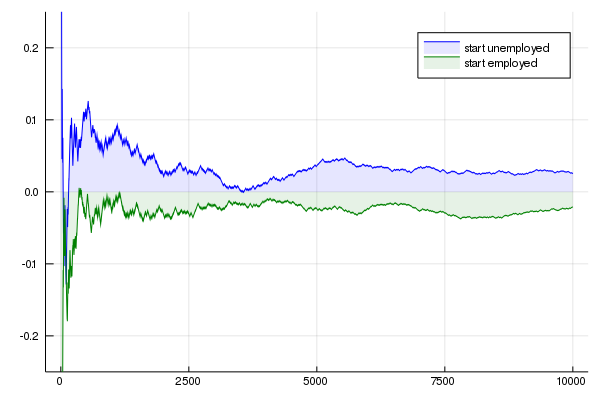

In [20]:
α = 0.1 # probability of getting hired
β = 0.1 # probability of getting fired
N = 10_000
p̄ = β / (α + β) # steady-state probabilities
P = [1 - α   α
     β   1 - β] # stochastic matrix
mc = MarkovChain(P)
labels = ["start unemployed", "start employed"]
y_vals = Array{Vector}(undef, 2) # sample paths holder

for x0 in 1:2
    X = simulate_indices(mc, N; init = x0) # generate the sample path
    X̄ = cumsum(X .== 1) ./ (1:N) # compute state fraction. ./ required for precedence
    y_vals[x0] = X̄ .- p̄ # plot divergence from steady state
end

plot(y_vals, color = [:blue :green], fillrange = 0, fillalpha = 0.1,
     ylims = (-0.25, 0.25), label = reshape(labels, 1, length(labels)))

### Exercise 2

In [21]:
web_graph_data = sort(Dict('a' => ['d', 'f'],
                           'b' => ['j', 'k', 'm'],
                           'c' => ['c', 'g', 'j', 'm'],
                           'd' => ['f', 'h', 'k'],
                           'e' => ['d', 'h', 'l'],
                           'f' => ['a', 'b', 'j', 'l'],
                           'g' => ['b', 'j'],
                           'h' => ['d', 'g', 'l', 'm'],
                           'i' => ['g', 'h', 'n'],
                           'j' => ['e', 'i', 'k'],
                           'k' => ['n'],
                           'l' => ['m'],
                           'm' => ['g'],
                           'n' => ['c', 'j', 'm']))

OrderedCollections.OrderedDict{Char,Array{Char,1}} with 14 entries:
  'a' => ['d', 'f']
  'b' => ['j', 'k', 'm']
  'c' => ['c', 'g', 'j', 'm']
  'd' => ['f', 'h', 'k']
  'e' => ['d', 'h', 'l']
  'f' => ['a', 'b', 'j', 'l']
  'g' => ['b', 'j']
  'h' => ['d', 'g', 'l', 'm']
  'i' => ['g', 'h', 'n']
  'j' => ['e', 'i', 'k']
  'k' => ['n']
  'l' => ['m']
  'm' => ['g']
  'n' => ['c', 'j', 'm']

In [22]:
nodes = keys(web_graph_data)
n = length(nodes)
# create adjacency matrix of links (Q[i, j] = true for link, false otherwise)
Q = fill(false, n, n)
for (node, edges) in enumerate(values(web_graph_data))
    Q[node, nodes .∈ Ref(edges)] .= true
end

# create the corresponding stochastic matrix
P = Q ./ sum(Q, dims = 2)

mc = MarkovChain(P)
r = stationary_distributions(mc)[1] # stationary distribution
ranked_pages = Dict(zip(keys(web_graph_data), r)) # results holder

# print solution
println("Rankings\n ***")
sort(collect(ranked_pages), by = x -> x[2], rev = true) # print sorted

Rankings
 ***


14-element Array{Pair{Char,Float64},1}:
 'g' => 0.16070778858515053 
 'j' => 0.15936158342833578 
 'm' => 0.119515123584059   
 'n' => 0.10876973827831275 
 'k' => 0.0910628956751643  
 'b' => 0.0832646081451476  
 'e' => 0.05312052780944526 
 'i' => 0.05312052780944526 
 'c' => 0.04834210590147233 
 'h' => 0.04560118369030004 
 'l' => 0.032017852378295776
 'd' => 0.030562495452009602
 'f' => 0.011642855410289372
 'a' => 0.002910713852572343

### Exercise 3

A solution from [QuantEcon.jl](https://github.com/QuantEcon/QuantEcon.jl) can be found [here](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/markov/markov_approx.jl)

**Footnotes**

<p><a id=pm href=#pm-link><strong>[1]</strong></a> Hint: First show that if $ P $ and $ Q $ are stochastic matrices then so is their product — to check the row sums, try postmultiplying by a column vector of ones.  Finally, argue that $ P^n $ is a stochastic matrix using induction.